In [9]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
import shap

# Consistent styling + reproducibility for neural network runs
plt.style.use("seaborn-v0_8")
np.random.seed(42)
tf.random.set_seed(42)


def evaluate_regression(y_true, y_pred, num_features, model_name="Model"):
    """Match the metric printouts from the other notebooks."""
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1) / (len(y_true) - num_features - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} R^2: {r2:.3f}")
    print(f"{model_name} Adjusted R^2: {adj_r2:.3f}")
    print(f"{model_name} MSE: {mse:.3f}")
    print(f"{model_name} RMSE: {rmse:.3f}")
    print(f"{model_name} MAE: {mae:.3f}")
    return {"r2": r2, "rmse": rmse, "mae": mae}


def plot_predictions(y_true, y_pred, title):
    """Scatter of actual vs. predicted sale prices in dollars."""
    actual = np.expm1(y_true)
    predicted = np.expm1(y_pred)
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, predicted, alpha=0.6, color="crimson")
    line_start = min(actual.min(), predicted.min())
    line_end = max(actual.max(), predicted.max())
    plt.plot([line_start, line_end], [line_start, line_end], "b-")
    plt.xlabel("Actual SalePrice ($)")
    plt.ylabel("Predicted SalePrice ($)")
    plt.title(title)
    plt.show()


def plot_residuals(y_true, y_pred, title):
    """Residual histogram to confirm errors center on zero."""
    residuals = y_true - y_pred
    sb.displot(residuals, bins=60, kde=True)
    plt.title(title)
    plt.xlabel("Residual (log dollars)")
    plt.show()


def plot_history(history, title):
    """Quick view of training vs. validation loss for debugging."""
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Train Loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.show()


In [10]:
# Load the prepared modeling table
nn_data = pd.read_csv("final.csv")
print(f"Prepared dataset shape: {nn_data.shape}")
nn_data.head()


Prepared dataset shape: (2930, 279)


,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,3.044522,4.955827,10.366309,6,1.791759,7.581210,1960,4.727388,6.461468,0.000000,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,4.394449,9.360741,5,1.945910,7.581720,1961,0.000000,6.150603,4.976734,...,False,False,False,True,False,False,False,False,True,False
2,3.044522,4.406719,9.565775,6,1.945910,7.580189,1958,4.691348,6.828712,0.000000,...,False,False,False,True,False,False,False,False,True,False
3,3.044522,4.543295,9.320181,7,1.791759,7.585281,1968,0.000000,6.971669,0.000000,...,False,False,False,True,False,False,False,False,True,False
4,4.110874,4.317488,9.534668,5,1.791759,7.599902,1998,0.000000,6.674561,0.000000,...,False,False,False,True,False,False,False,False,True,False


In [11]:
# Split into inputs and the log SalePrice target
X = nn_data.drop('SalePrice', axis=1)
y = nn_data['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training rows: {x_train.shape[0]}, Testing rows: {x_test.shape[0]}, Features: {x_train.shape[1]}")


Training rows: 2344, Testing rows: 586, Features: 278


In [ ]:
# Scale features for neural network training
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled.shape, x_test_scaled.shape


((2344, 278), (586, 278))

Basic Keras ANN R^2: -4.248
Basic Keras ANN Adjusted R^2: -9.000
Basic Keras ANN MSE: 0.971
Basic Keras ANN RMSE: 0.985
Basic Keras ANN MAE: 0.606


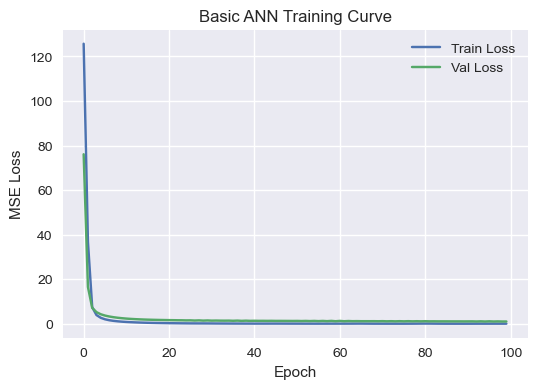

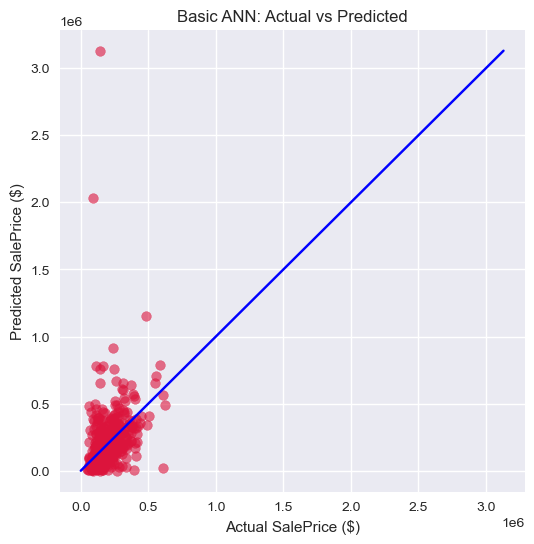

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


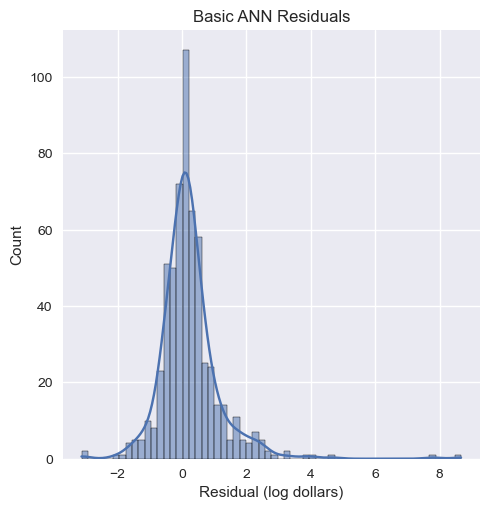

In [ ]:
# Train the basic ANN model with a single hidden layer
def build_basic_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model


basic_ann = build_basic_ann(x_train_scaled.shape[1])
history_basic = basic_ann.fit(
    x_train_scaled,
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=0
)

basic_pred = basic_ann.predict(x_test_scaled, verbose=0).ravel()
_ = evaluate_regression(y_test, basic_pred, x_test.shape[1], "Basic Keras ANN")
plot_history(history_basic, "Basic ANN Training Curve")
plot_predictions(y_test, basic_pred, "Basic ANN: Actual vs Predicted")
plot_residuals(y_test, basic_pred, "Basic ANN Residuals")


Advanced Keras ANN R^2: -1.007
Advanced Keras ANN Adjusted R^2: -2.825
Advanced Keras ANN MSE: 0.371
Advanced Keras ANN RMSE: 0.609
Advanced Keras ANN MAE: 0.420


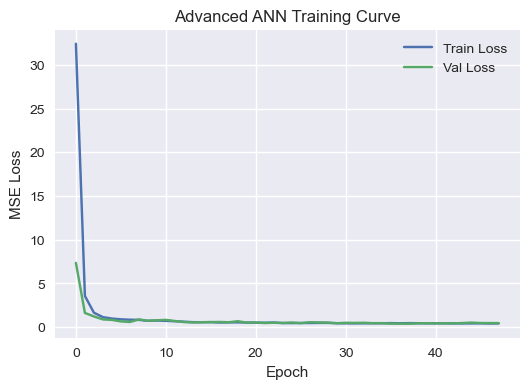

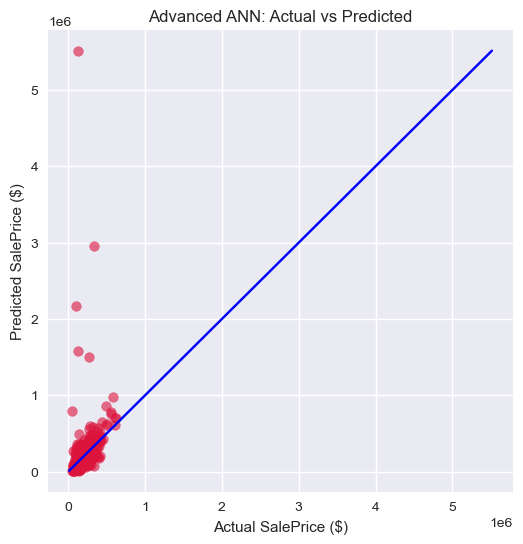

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


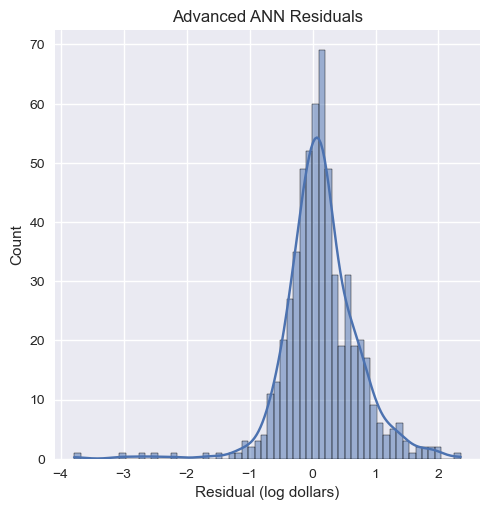

In [ ]:
# Train the advanced ANN model with deeper architecture and regularization
def build_advanced_ann(input_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    return model


advanced_ann = build_advanced_ann(x_train_scaled.shape[1])
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)
]

history_adv = advanced_ann.fit(
    x_train_scaled,
    y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=0
)

adv_pred = advanced_ann.predict(x_test_scaled, verbose=0).ravel()
_ = evaluate_regression(y_test, adv_pred, x_test.shape[1], "Advanced Keras ANN")
plot_history(history_adv, "Advanced ANN Training Curve")
plot_predictions(y_test, adv_pred, "Advanced ANN: Actual vs Predicted")
plot_residuals(y_test, adv_pred, "Advanced ANN Residuals")


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(200, 278))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(400, 278))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_12
Received: inputs=['Tensor(shape=(100

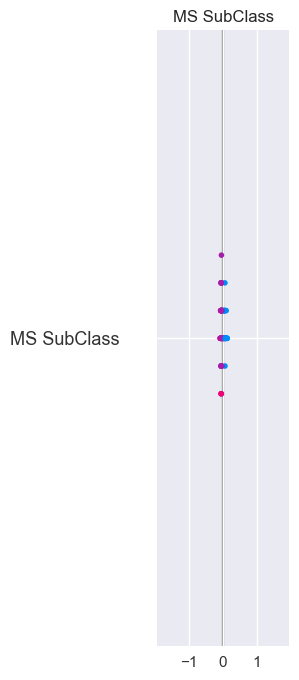

In [16]:
# SHAP: inspect which inputs drive the advanced ANN predictions
background_size = min(200, x_train_scaled.shape[0])
background_idx = np.random.choice(x_train_scaled.shape[0], background_size, replace=False)
background_data = x_train_scaled[background_idx]

test_size = min(100, x_test_scaled.shape[0])
test_idx = np.random.choice(x_test_scaled.shape[0], test_size, replace=False)
explainer = shap.DeepExplainer(advanced_ann, background_data)
shap_values = explainer.shap_values(x_test_scaled[test_idx])

# Convert the scaled test data back to a DataFrame so SHAP can label features correctly
test_sample_df = pd.DataFrame(x_test_scaled[test_idx], columns=X.columns)
shap.summary_plot(shap_values, test_sample_df, plot_type="bar")
